# Simulations - 1 

In [2]:
library(repr)
options(repr.plot.width=7, repr.plot.height=5, repr.plot.res = 120, repr.plot.quality = 30)
options(jupyter.plot_mimetypes = 'image/png')

In [8]:
setwd("~/yandexDisk/DIPLOMA/CODE/src/")
source("./simulations.functions.R", echo=FALSE)
save.image("../.various.Rdata/TestingSimulations")

In [4]:
# Defining control execution constants 
train.data.sample.sizes <- c(50, 100, 200, 400, 800)
test.data.sample.size <- 10000
number.of.covariates = 30
sample.size <-  50
offsets = seq(0.1, 1, length = 10)
control.offset = min(offsets) / 2
lambdas = seq(0.1,  10,  length=10)

registerDoParallel(cores = 4)
number.of.simulations <- 3

In [5]:
# prepare train data
train <- GetSimulationData(sample.size, number.of.covariates)
# prepare test data
test <- GetSimulationData(test.data.sample.size, number.of.covariates)

In [9]:
global.result <- list()
for (offset in  offsets) {
  cat("Optimization offset: ", offset, "\n")
  result <- foreach (lambda = lambdas) %dopar% {
    folds <- createFolds(train$treatment)
      
    dtr.values.on.folds.dca.mm <- GetDtrValuesOnFolds(folds, train, offset, control.offset, 
        PolicyFunLinearKernel, lambda, opt.hyperparams = list("opt.func"=DCOptimizeWithMML2Penalized))
    opt.params.dca.mm <- OptimizeParamsOfPolicyFunction(train, offset, PolicyFunLinearKernel, lambda,
        opt.hyperparams = list("opt.func"=DCOptimizeWithMML2Penalized))
    dtr.value.on.test.dca.mm <- ValueFunction(opt.params.dca.mm, test, offset, PolicyFunLinearKernel)
      
    dtr.values.on.folds.dca.l1 <- GetDtrValuesOnFolds(folds, train, offset, control.offset, 
        PolicyFunLinearKernel, lambda, opt.hyperparams = list("opt.func"=DCOptimizeL1Penalized))
    opt.params.dca.l1 <- OptimizeParamsOfPolicyFunction(train, offset, PolicyFunLinearKernel, lambda,
        opt.hyperparams = list("opt.func"=DCOptimizeL1Penalized))
    dtr.value.on.test.dca.l1 <- ValueFunction(opt.params.dca.l1, test, offset, PolicyFunLinearKernel)


    return (list("offset"=offset, "lambda"=lambda,
                 "dtr.values.on.folds.dca.mm"=dtr.values.on.folds.dca.mm,
                 "dtr.value.on.test.dca.mm"=dtr.value.on.test.dca.mm,
                 "dtr.values.on.folds.dca.l1"=dtr.values.on.folds.dca.l1,
                 "dtr.value.on.test.dca.l1"=dtr.value.on.test.dca.l1))
  }
  global.result <- c(global.result, result)
}

Optimization offset:  0.1 


ERROR: Error in {: task 1 failed - "Infinite iterations in MM algorithm!"


Выбранные по кроссвалидации параметры:

In [34]:
# create result matrix with statistics for every params combination tested
result.to.plot <- as.data.frame(t(sapply(global.result, cbind)))
colnames(result.to.plot)  <- names(global.result[[1]])

result.to.plot$sd.mm <- sapply(result.to.plot$dtr.values.on.folds.dca.mm, sd)
result.to.plot$sd.l1 <- sapply(result.to.plot$dtr.values.on.folds.dca.l1, sd)

result.to.plot$mean.folds.dtr.value.dca.mm <- sapply(
   result.to.plot$dtr.values.on.folds.dca.mm, mean)
result.to.plot$mean.folds.dtr.value.dca.l1 <- sapply(
   result.to.plot$dtr.values.on.folds.dca.l1, mean)

for (column in c("offset", "lambda", "dtr.value.on.test.dca.mm", 
                 "dtr.value.on.test.dca.l1" )) {
    result.to.plot[column] <- as.numeric(unlist(result.to.plot[column]))
}
result.to.plot$lambda  <- as.factor(result.to.plot$lambda)

pars.dca.mm <-  result.to.plot[ which.max(result.to.plot$mean.folds.dtr.value.dca.mm),  ]
pars.dca.l1<-  result.to.plot[ which.max(result.to.plot$mean.folds.dtr.value.dca.l1),  ]

cat("Choosen params by CV MM algorithm:")
pars.dca.mm
cat("Choosen params by CV l1 algorithm:")
pars.dca.l1

best.offset.dca.mm <- as.numeric(pars.dca.mm$offset)
best.lambda.dca.mm <- as.numeric(as.character(pars.dca.mm$lambda))

best.offset.dca.l1 <- as.numeric(pars.dca.l1$offset)
best.lambda.dca.l1 <- as.numeric(as.character(pars.dca.l1$lambda))

opt.params.dca.mm <- OptimizeParamsOfPolicyFunction(train, best.offset.dca.mm, PolicyFunLinearKernel, 
    best.lambda.dca.mm, opt.hyperparams = list("opt.func"=DCOptimizeWithMML2Penalized))
opt.params.dca.l1 <- OptimizeParamsOfPolicyFunction(train, best.offset.dca.l1, PolicyFunLinearKernel, 
    best.lambda.dca.l1, opt.hyperparams = list("opt.func"=DCOptimizeL1Penalized))


ERROR: Error in global.result[[1]]: subscript out of bounds


ERROR: Error in `$<-.data.frame`(`*tmp*`, "sd.mm", value = list()): replacement has 0 rows, data has 1


ERROR: Error in `$<-.data.frame`(`*tmp*`, "sd.l1", value = list()): replacement has 0 rows, data has 1


ERROR: Error in `$<-.data.frame`(`*tmp*`, "mean.folds.dtr.value.dca.mm", value = list()): replacement has 0 rows, data has 1


ERROR: Error in `$<-.data.frame`(`*tmp*`, "mean.folds.dtr.value.dca.l1", value = list()): replacement has 0 rows, data has 1


ERROR: Error in `[.data.frame`(result.to.plot, column): undefined columns selected


ERROR: Error in `$<-.data.frame`(`*tmp*`, "lambda", value = structure(integer(0), .Label = character(0), class = "factor")): replacement has 0 rows, data has 1


Choosen params by CV MM algorithm:

numeric(0)

Choosen params by CV l1 algorithm:

numeric(0)

ERROR: Error in pars.dca.mm$offset: $ operator is invalid for atomic vectors


ERROR: Error in pars.dca.mm$lambda: $ operator is invalid for atomic vectors


ERROR: Error in pars.dca.l1$offset: $ operator is invalid for atomic vectors


ERROR: Error in pars.dca.l1$lambda: $ operator is invalid for atomic vectors


In [35]:
result.to.plot[, c("dtr.value.on.test.dca.mm",  "mean.folds.dtr.value.dca.mm", 
                   "dtr.value.on.test.dca.l1",  "mean.folds.dtr.value.dca.l1" )]

ERROR: Error in `[.data.frame`(result.to.plot, , c("dtr.value.on.test.dca.mm", : undefined columns selected


In [36]:
ggplot(result.to.plot, aes(x = offset, y = mean.folds.dtr.value.dca.mm, colour = lambda)) +
#   geom_errorbar(aes(ymin=mean.folds.dtr.value.dca.mm-sd.mm, 
#                       ymax=mean.folds.dtr.value.dca.mm+sd.mm), width=0.01) +
  geom_line() +
  ggtitle("Cross validation results for DCA MM otimization")

ggplot(result.to.plot, aes(x = offset, y = mean.folds.dtr.value.dca.l1, colour = lambda)) +
#   geom_errorbar(aes(ymin=value.function.dca-sd, 
#                       ymax=value.function.dca+sd), width=0.01) +
  geom_line() +
  ggtitle("Cross validation results for DCA L1 optimization")

ERROR: Error in eval(expr, envir, enclos): object 'mean.folds.dtr.value.dca.mm' not found


ERROR: Error in eval(expr, envir, enclos): object 'mean.folds.dtr.value.dca.l1' not found


ERROR: Error in file(con, "rb"): cannot open the connection


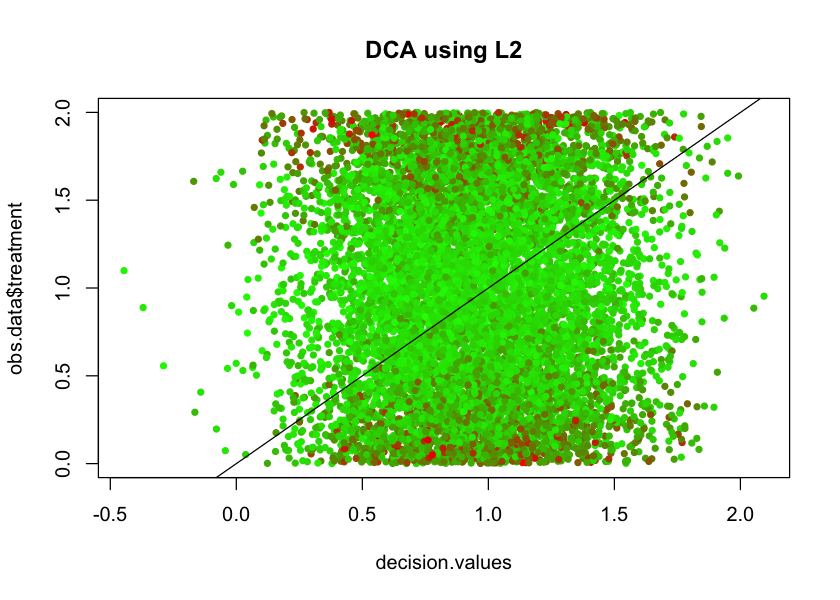

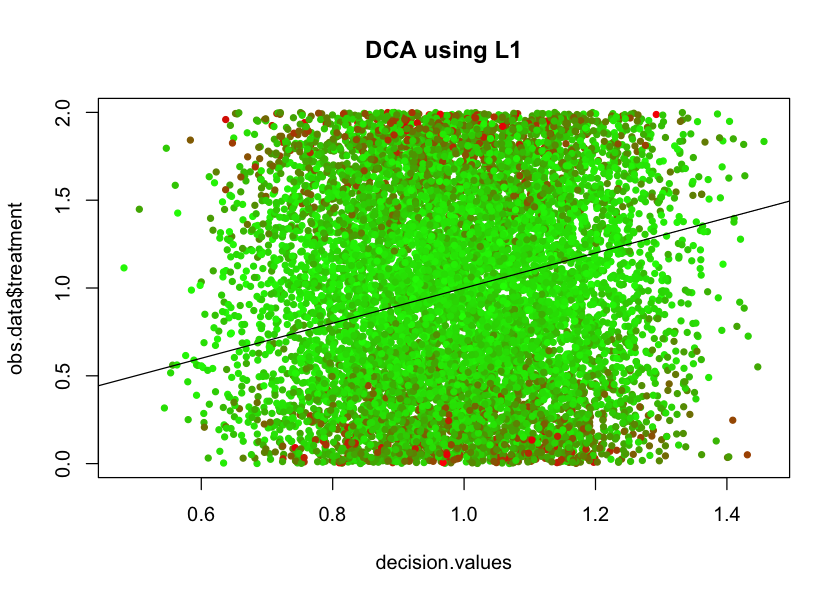

In [37]:
PlotDecsionsVersusObserved(test, PolicyFunLinearKernel, opt.params.dca.mm, "DCA using L2")
PlotDecsionsVersusObserved(test, PolicyFunLinearKernel, opt.params.dca.l1, "DCA using L1")

In [14]:
plot(density(decision.values), col="green", lwd=4,  ylim=c(0, 1.9),
     main = "Treatment density")
lines(density(test.treatment), col="blue", lwd=4)
legend("topleft", c("Recommended by DTR", "Observed"),
       lwd=c(2.5,2.5),col=c("green","blue"), bty = "n")

ERROR: Error in density(decision.values): object 'decision.values' not found


ERROR: Error in density(test.treatment): object 'test.treatment' not found


ERROR: Error in strwidth(legend, units = "user", cex = cex, font = text.font): plot.new has not been called yet


In [431]:
# get best possible combinations of lambda and offset based on test performance
best.index <- which.max(result.to.plot$dtr.value.on.test.dca)
cat("Best possible result:")
result.to.plot[best.index, ]

best.lambda.on.test <- result.to.plot[best.index, "lambda"]
best.offset.on.test <- result.to.plot[best.index, "offset"]

Best possible result:

,offset,lambda,dtr.values.on.folds.dca,dtr.value.on.test.dca,sd,mean.folds.dtr.value.dca
6,0.2,4.54545454545454,"0.3595162, -2.1026798, 0.0000000, 0.0000000, 1.9902205, 1.8695794, 5.4686287, 2.9714395, -1.0753593, 2.3388572",1.443837,2.195883,1.18202


ERROR: Error in OptimizeParamsOfPolicyFunction(train.treatment, train.covariates, : unused arguments (PolicyFunLinearKernel, best.lambda.on.test)


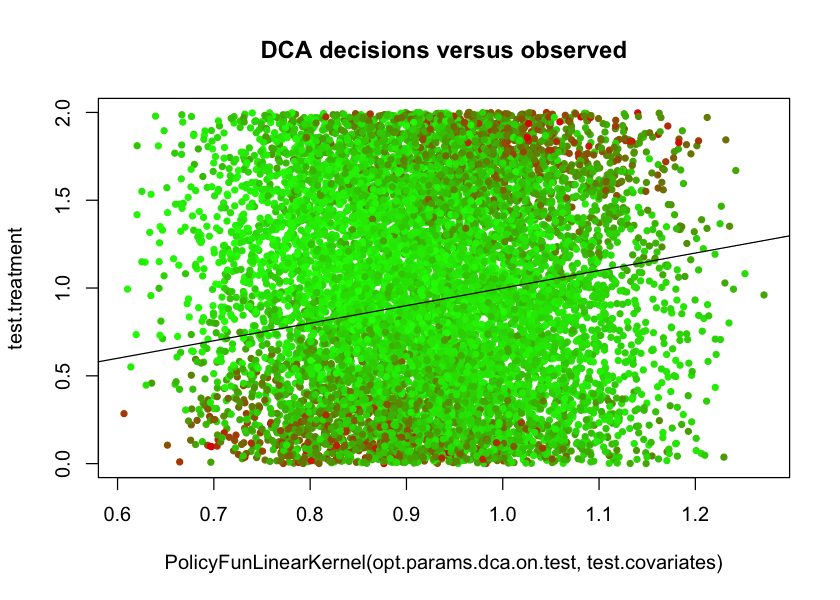

In [432]:
# Plot best decision possible (on test data)
opt.params.dca.on.test <- OptimizeParamsOfPolicyFunction(train, best.offset.on.test,
    PolicyFunLinearKernel, best.lambda.on.test)

rewards.scaled.0.1 <- (test.reward - min(test.reward) ) /
                      (max(test.reward) - min(test.reward))
plot(PolicyFunLinearKernel(opt.params.dca.on.test, test.covariates),
     test.treatment,
     col=rgb(1 - rewards.scaled.0.1, rewards.scaled.0.1, 0),
     pch=20, main="DCA decisions versus observed")
abline(0, 1)

# Проблемы

1. Почему обращается value function в 0 на тестовой выборке с ростом параметра сдвига ?

    > Потому что мы оцениваем сравниваем между собой ценности DTR на заданном фиксированном и малом отступе $\varphi = 0.005$ Ноль получается потому что в радиус этого отступа относительно наблюденного treatment не попадет наш предсказанный treatment ни для какого из предсказаний. Все, что показано ниже сделано для увеличенного в 10 раз $\varphi = 0.005 \to \varphi = 0.05$ 

2. Попробовать сдвигать обратно reward перед вычислением value function ?
    > Попробовал оптимизировать только по сдвинутым значениям value function, а оценивать в процессе CV  с помощью сырых reward. Результат интересный. В двух словах, идеальный value function на тестовых данных держится в районе 1.5, что ближе, чем полученное ранее $\sim 40$. Правда я еще прикрутил дополнительно CBPS в two step mode.    

3. Попробовать квадрат / логарифм / : неотрицательность дозы
     > Учитывая, что в отрицательную область предсказания перестали уходить, это не делал

4. Попробовать lambda=0

    > При кросс валидации видно, что это далеко не лучший способ, дает хуже результаты, чем при каком-нибудь другом $\lambda$. 

5. Попробовать быструю оптимизацию которая умеет много параметров вместо annealing

    > ** Пока не успел **

6. Написать деревьям, если не ответят - на mail list R help 

    > Написал деревьям, код MIDAs у нас есть. Они его не выложили еще в публичный доступ, потому что в процессе допиливания кода на fortran, который под капотом у этого MIDAs

7. Почему при $\lambda \to \infty$ мы получаем наилучшее value func  в  симуляции?

    > Причинной этому является то, что у нас очень интересно расположены точки в симуляции. При крайних значениях treatment (вблизи 0 и вблизи 2.0) мы имеем большинство плохих резульататов. Поэтому  linear DTR  стремится стать вообще горизонтальной линией $y=1$. 

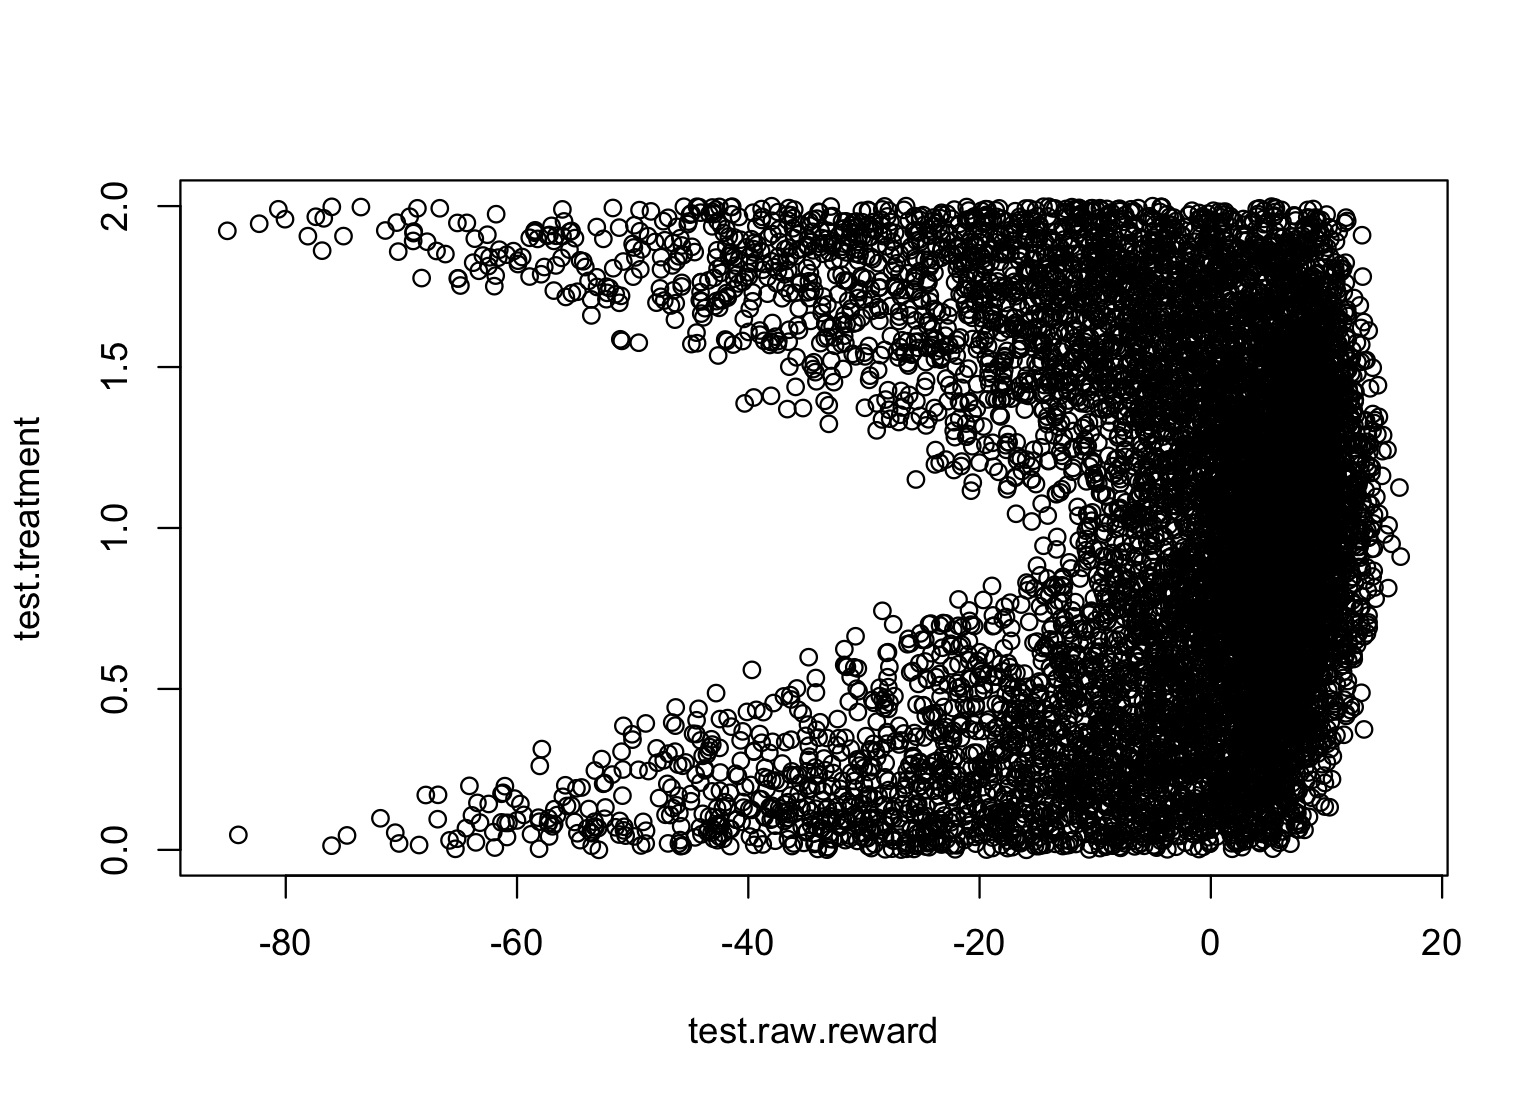

In [245]:
plot(test.raw.reward, test.treatment)

# Вопросы

### Даже если допустить, что мы знаем идеальное решение (т.е. заранее знаем какие коэффициенты должны быть в линейной модели), то все равно не получается value function настолько большой, как у Kosorok). Иллюстрация:

Ideal DTR value function =  6.250823

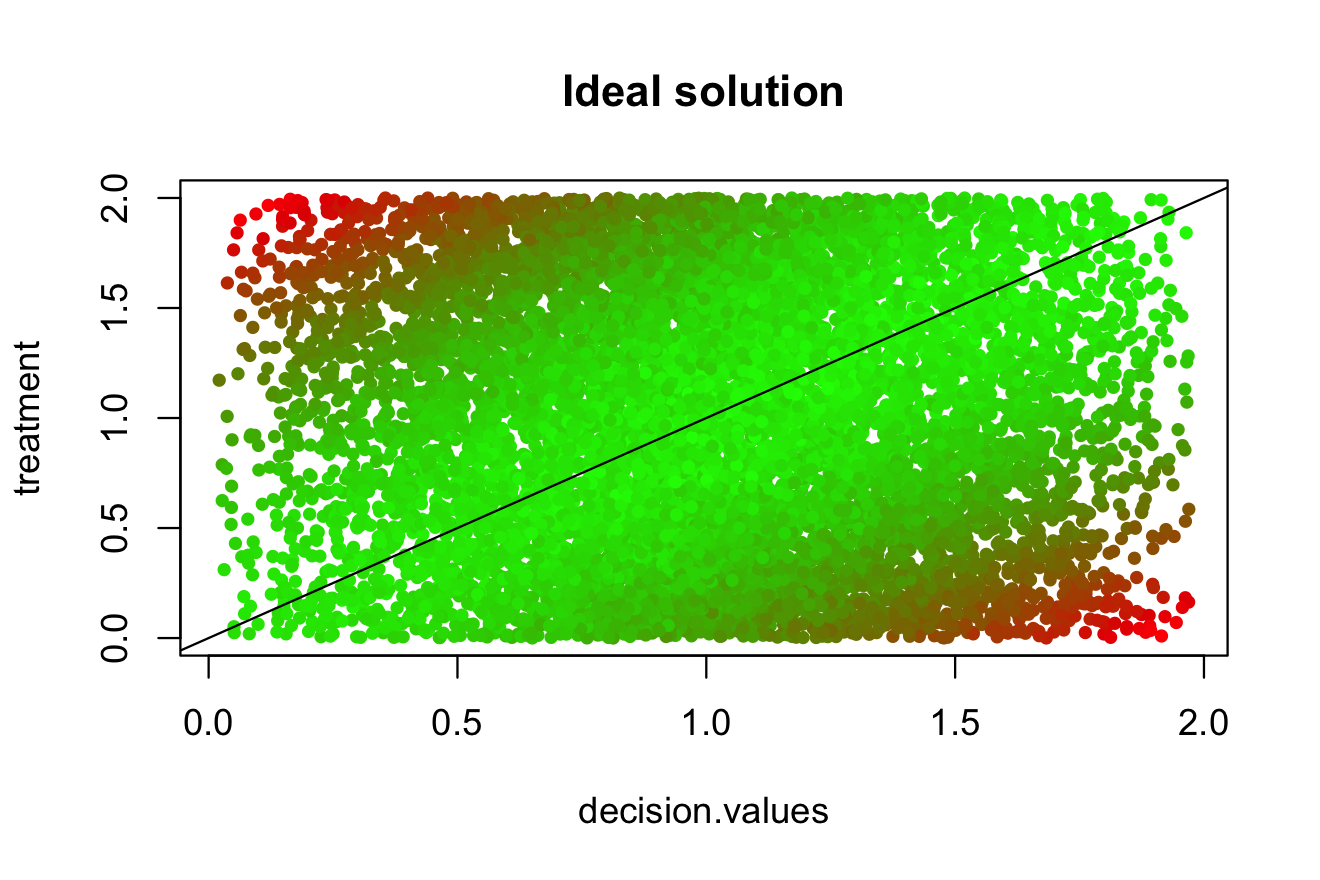

In [311]:
opt.decision <- c(1, 0.5, 0.5 , rep(0, length(opt.params.dca) -3 ))
names(opt.decision) <- names(opt.params.dca)
plot.decsions.versus.observed(test.treatment, test.covariates, test.reward, PolicyFunLinearKernel, opt.decision, 
                             title="Ideal solution")
dtr.value.on.test.ideal <- ValueFunction(opt.decision, test.treatment,
    test.covariates,  test.prop.scores,  test.raw.reward,
    offset, PolicyFunLinearKernel)
cat("Ideal DTR value function = ", dtr.value.on.test.ideal)

**<font color='red'> И даже при таком запуске, невозможно получить большое значение средней суррогатной функции! </font>** 

Как у него получилось это значение $> 7$, для меня пока загадка.

In [351]:
results <- c()
for (i in seq(0, 10)) {
    test.data <- GetSimulationData(test.data.sample.size, number.of.covariates)
    dtr.value.on.test.ideal <-  ValueFunction(params = opt.decision, obs.data = test.data, 
                  offset = control.offset, policy.function = PolicyFunLinearKernel)
    results <- c(results, dtr.value.on.test.ideal)
}

cat("Mean ideal DTR value = ", mean(results)) 

Mean ideal DTR value =  13.12268

### Следующий вопрос

In [350]:
test.data.list <- GetSimulationData(test.data.sample.size, number.of.covariates)
ValueFunction(params = opt.decision, obs.data = test.data.list, 
              offset = control.offset, policy.function = PolicyFunLinearKernel)

[1] 12.29184